# Factor Analysis

by Maxwell Margenot, Gil Wassermann, and Delaney Granizo-Mackenzie. Code segments by James Christopher Hall

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [https://github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License. Please do not remove this attribution.

---

How can we tell whether an alpha factor is good or not? Unfortunately, there is no cut-off that tells you whether a factor is objectively useful. Instead, we need to compare a particular factor to other options before deciding whether to use it. Our end goal in defining and selecting the best factors is to use them to rank stocks in a long-short equity strategy, covered elsewhere in the [lecture series](https://www.quantopian.com/lectures#Long-Short-Equity). The more independent predictive the factors we use, the better our ranking scheme and our overall strategy will be.


What we want when comparing factors is to make sure the chosen signal is actually predictive of **relative price movements**. We do not want to predict the absolute amount the assets in our universe will move up or down. We only care that we can choose assets to long that will do better than the assets we short. In a long-short equity strategy, we hold a long basket and a short basket of assets, determined by the factor values associated with each asset in our universe. If our ranking scheme is predictive, this means that assets in the top basket will tend to outperform assets in the bottom basket. As long this spread is consistent over time our strategy will have a positive return.


An individual factor can have a lot of moving parts to assess, but ideally it should be independent of other factors that you are already trading on in order to keep your portfolio diverse. We discuss the reasoning for this in [this lecture](https://www.quantopian.com/lectures#Position-Concentration-Risk). 


In this lecture, we detail and explain relevant statistics to evaluate your alpha factor before attempting to implement it in an algorithm. What's important to keep in mind is that all the metrics provided here are relative to other factors you may be trading or evaluating. 


Let's have a look at a factor and try to assess its viability. We will calculate the factor values using Pipeline, so make sure you check out the [tutorial](https://www.quantopian.com/tutorials/pipeline) if you are unfamiliar with how Pipeline works.

In [1]:
import numpy as np
import pandas as pd
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import CustomFactor, Returns
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.filters import Q1500US
from time import time

### Momentum

Here we will be using a **momentum** factor as our example. Momentum factors are a very common form of alpha factor and they come in many shapes and sizes. They all try to get at the same idea, however, that securities in motion will stay in motion. Momentum factors try to quantify trends in financial markets and to "ride the wave", so to speak.

Let's say that we suspect that a momentum factor could potentially be predictive of stock returns. We define it as a `CustomFactor` so that we can easily pull its values when we run our Pipeline. We should get a factor value for every security in our universe.

In [2]:
class MyFactor(CustomFactor):
        """ Momentum factor """
        inputs = [USEquityPricing.close,
                  Returns(window_length=126)]
        window_length = 252

        def compute(self, today, assets, out, prices, returns):
            out[:] = ((prices[-21] - prices[-252])/prices[-252] -
                      (prices[-1] - prices[-21])/prices[-21]) / np.nanstd(returns, axis=0)

This momentum factor takes the change in price over the past year, up until a month ago, and standardizes it over the the change in price over the last month. This allows it to account for any changes over the past month and use them to temper its expectations of future movement.

## Judging a Factor with Alphalens

In order to judge whether a factor is viable, we have created a package called Alphalens. Its source code is available on [github](http://github.com/quantopian/alphalens) if you want to get into the nitty-gritty of how it works. We use Alphalens to create a "tear sheet" of a factor, similar to how we use [pyfolio](http://github.com/quantopian/pyfolio) to create a tear sheet for analyzing backtests.

In [3]:
import alphalens as al

Alphalens takes your factor and examines how useful it is for predicting relative value through a collection of different metrics. It breaks all the stocks in your chosen universe into different quantiles based on their ranking according to your factor and analyzes the returns, information coefficient (IC), the turnover of each quantile, and provides a breakdown of returns and IC by sector.

Throughout the course of this lecture we will detail how to interpret the various individual plots generated by an `Alphalens` tearsheet and include the proper call to generate the whole tearsheet at once at the end.

## Sector Codes

These are the possible sector codes for each security, as given by Morningstar. We will use this dictionary to help categorize our results as we walk through a factor analysis so that we can break out our information by sector.

In [4]:
MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

## Defining a universe

As always, we need to define our universe. In this case we use the Q1500US, as seen in the forums [here](https://www.quantopian.com/posts/the-q500us-and-q1500us).

In [5]:
universe = Q1500US()

## Getting Data

Now we will pull values for our factor for all stocks in our universe by using Pipeline. We also want to make sure that we have the sector code for each individual equity, so we add `Sector` as another factor for our Pipeline. Note that running the Pipeline may take a while.

In [6]:
pipe = Pipeline(
    columns = {
            'MyFactor' : MyFactor(mask=universe),
            'Sector' : Sector(mask=universe)
    },
    screen=universe
)

start_timer = time()
results = run_pipeline(pipe, '2015-01-01', '2016-01-01')
end_timer = time()
results.fillna(value=0);

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


In [7]:
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 72.40 secs


Let's take a look at the data to get a quick sense of what we have.

In [8]:
my_factor = results['MyFactor']
print my_factor.head()

2015-01-02 00:00:00+00:00  Equity(2 [ARNC])     5.239913
                           Equity(24 [AAPL])    5.451305
                           Equity(41 [ARCB])    1.155913
                           Equity(62 [ABT])     4.818421
                           Equity(67 [ADSK])    1.724293
Name: MyFactor, dtype: float64


Our `my_factor` variable contains a pandas `Series` with a factor value for each equity in our universe for each point in time.

Here we create another `Series` that contains sector codes for each equity instead of factor values. This is categorical data that we will use as a parameter for `Alphalens` later.

In [9]:
sectors = results['Sector']

While our universe is defined to consist of 1500 stocks, the actual number of unique stocks that we end up ranking will likely  be greater than this due to stocks passing in and out of our filters. For this reason, we grab pricing data for any stock that may have been in our Pipeline at some point to make sure that we have all of the data that we might need.

In [10]:
asset_list = results.index.levels[1].unique()

In [11]:
prices = get_pricing(asset_list, start_date='2015-01-01', end_date='2016-02-01', fields='open_price')

In [12]:
prices.head()

,Equity(2 [ARNC]),Equity(24 [AAPL]),Equity(41 [ARCB]),Equity(53 [ABMD]),Equity(62 [ABT]),Equity(67 [ADSK]),Equity(76 [TAP]),Equity(88 [ACI]),Equity(110 [ACXM]),Equity(114 [ADBE]),...,Equity(48821 [CJES]),Equity(48823 [SEDG]),Equity(48863 [GDDY]),Equity(48892 [IGT]),Equity(48934 [ETSY]),Equity(48962 [CSAL]),Equity(49003 [TLN]),Equity(49051 [APLE]),Equity(49141 [CPGX]),Equity(49496 [FDC])
2015-01-02 00:00:00+00:00,47.61,111.39,46.69,38.27,45.25,60.06,74.64,177.0,20.34,72.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05 00:00:00+00:00,46.92,108.29,45.61,37.17,44.67,59.15,73.39,168.0,19.44,72.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06 00:00:00+00:00,45.06,106.68,45.20,37.09,44.99,58.89,73.91,161.0,19.48,71.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07 00:00:00+00:00,45.84,107.18,43.55,36.42,44.73,57.78,74.00,153.0,19.20,70.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08 00:00:00+00:00,46.92,109.23,42.44,37.69,45.19,57.87,77.04,152.0,19.59,71.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Alphalens Components

Now that we have the basic components of what we need to analyze our factor, we can start to deal with `Alphalens`. Note that we will be breaking out individual components of the package, so this is not the typical workflow for using an `Alphalens` tear sheet.

First we get our factor categorized by sector code and calculate our forward returns. The forward returns are the returns that we would have received for holding each security over the day periods ending on the given date, passed in through the `periods` parameter. In our case, and by default, we look $1$, $5$, and $10$ days in advance. We can consider this a budget backtest. The tear sheet does not factor in any commission or slippage cost, rather, it only considers values as if we had magically already held the specified equities for the specified number of days up to the current day.

In [13]:
factor, forward_returns = al.utils.get_clean_factor_and_forward_returns(factor=my_factor,
                                                                        prices=prices,
                                                                        groupby=sectors,
                                                                        groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                                        periods=(1,5,10))

The `factor` variable here is similar to the `my_factor` variable above. It has a factor value for every equity in our universe at each point in time. Our `Alphalens` function here has also provided a sector grouping to go along with the factor value.

In [14]:
factor.head()

date                       asset              group          
2015-01-02 00:00:00+00:00  Equity(2 [ARNC])   Basic Materials    5.239913
                           Equity(24 [AAPL])  Technology         5.451305
                           Equity(41 [ARCB])  Industrials        1.155913
                           Equity(62 [ABT])   Healthcare         4.818421
                           Equity(67 [ADSK])  Technology         1.724293
Name: factor, dtype: float64

As explained above, the forward returns are the returns that we would have received for holding each security for the specified number of days, ending on the given date. These, too, are broken out by sector.

In [15]:
forward_returns.head()

1   \
date                      asset             group                       
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])  Basic Materials -0.014493   
                          Equity(24 [AAPL]) Technology      -0.027830   
                          Equity(41 [ARCB]) Industrials     -0.023131   
                          Equity(62 [ABT])  Healthcare      -0.012818   
                          Equity(67 [ADSK]) Technology      -0.015152   

                                                                   5   \
date                      asset             group                       
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])  Basic Materials  0.002008   
                          Equity(24 [AAPL]) Technology       0.002288   
                          Equity(41 [ARCB]) Industrials     -0.015828   
                          Equity(62 [ABT])  Healthcare       0.001322   
                          Equity(67 [ADSK]) Technology      -0.004299   

                                                                   10  
date                      asset             group                      
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])  Basic Materials -0.005888  
                          Equity(24 [AAPL]) Technology      -0.003985  
                          Equity(41 [ARCB]) Industrials     -0.014000  
                          Equity(62 [ABT])  Healthcare      -0.003252  
                          Equity(67 [ADSK]) Technology      -0.007704

Now we take our factor and separate it into quantiles for each date, replacing the factor value with its appropriate quantile on a given day. Since we will be holding baskets of the top and bottom quantiles, we only care about the factor insofar as it relates to movement into and out of these baskets.

In [16]:
quantized_factor = al.performance.quantize_factor(factor)

In [17]:
quantized_factor.head()

date                       asset              group          
2015-01-02 00:00:00+00:00  Equity(2 [ARNC])   Basic Materials    5
                           Equity(24 [AAPL])  Technology         5
                           Equity(41 [ARCB])  Industrials        3
                           Equity(62 [ABT])   Healthcare         5
                           Equity(67 [ADSK])  Technology         4
Name: quantile, dtype: int64

We take this quantized factor and calculate the returns for each basket (quantile) over the given day periods.

In [18]:
mean_return_by_q_daily, std_err_by_q_daily = al.performance.mean_return_by_quantile(quantized_factor,
                                                                                    forward_returns,
                                                                                    by_group=False,
                                                                                    by_date=True)

In [19]:
mean_return_by_q_daily.head()

1         5         10
date                      quantile                              
2015-01-02 00:00:00+00:00 1        -0.001571 -0.004702 -0.004539
                          2        -0.002582 -0.001431 -0.002259
                          3        -0.001277 -0.000129 -0.000303
                          4         0.002076  0.002256  0.002645
                          5         0.003348  0.004008  0.004456

With the `by_date` boolean flag, we decide whether to look at our quantized returns either as a time series or as a point estimate. Here we calculate only the point estimates.

In [20]:
mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(quantized_factor,
                                                                         forward_returns,
                                                                         by_group=False,
                                                                         by_date=False)

In [21]:
mean_return_by_q.head()

,1,5,10
quantile,,,
1,-0.000767,-0.000889,-0.000957
2,-0.000059,-0.000050,-0.000014
3,0.000206,0.000210,0.000226
4,0.000219,0.000303,0.000293
5,0.000403,0.000427,0.000454


These point estimates were also calculated agnostic of the sector groupings so they give us an overall view of what our spread would look like if we traded this factor with a long-short equity algorithm and didn't examine which sectors those returns were coming from.

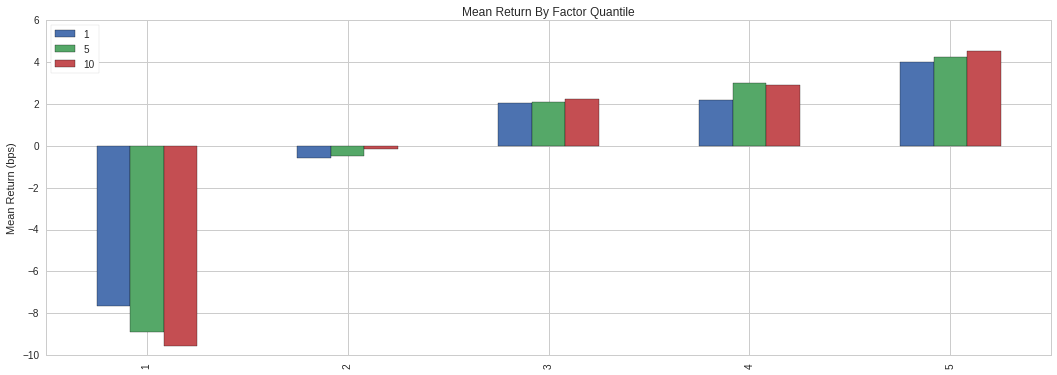

In [22]:
al.plotting.plot_quantile_returns_bar(mean_return_by_q);

Here we construct the violin plots of our time series of quantile returns. A violin plot shows the density of our data. The fatter the violin, the higher the density of returns in that region. Here we plot the violins for the $1$, $5$, and $10$ day forward returns for each quantile.

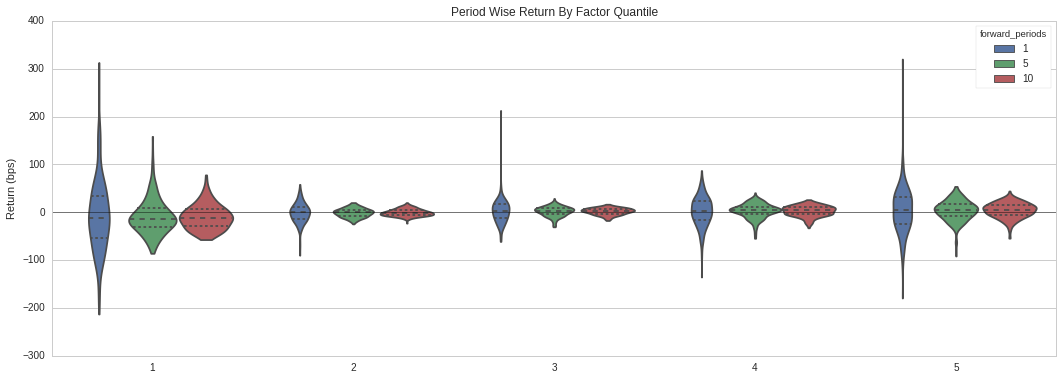

In [23]:
al.plotting.plot_quantile_returns_violin(mean_return_by_q_daily);

Here we calculate the basis points of the spread, based on subtracting the mean return of the lowest quantile from the mean return of the highest quantile (simulating going short on the lowest and long on the highest). We also get the error and plot it all together, giving us a time series of the basis points with confidence intervals for each time period.

In [24]:
quant_return_spread, std_err_spread = al.performance.compute_mean_returns_spread(mean_return_by_q_daily,
                                                                                 5,
                                                                                 1,
                                                                                 std_err_by_q_daily)

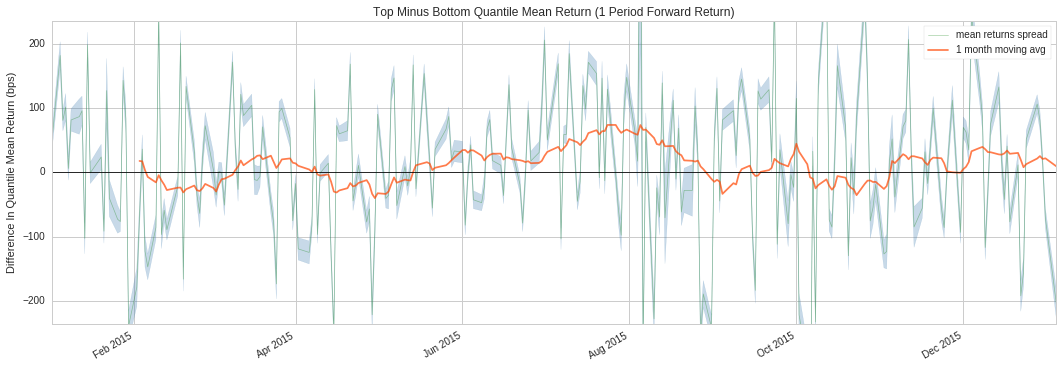

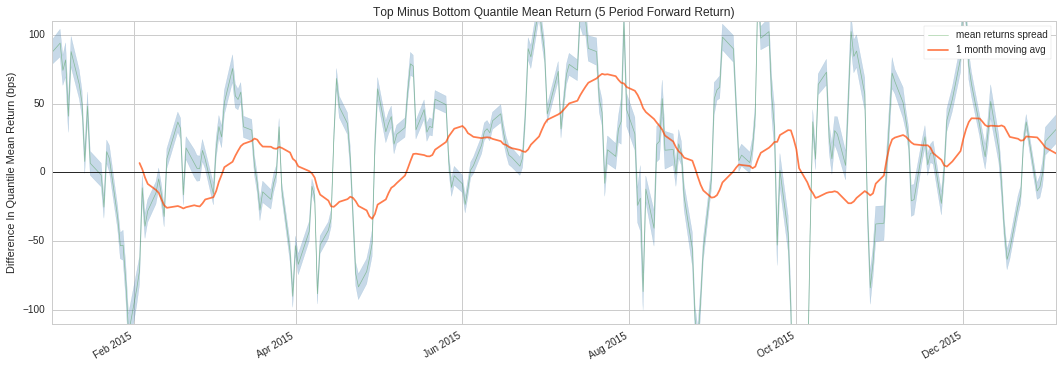

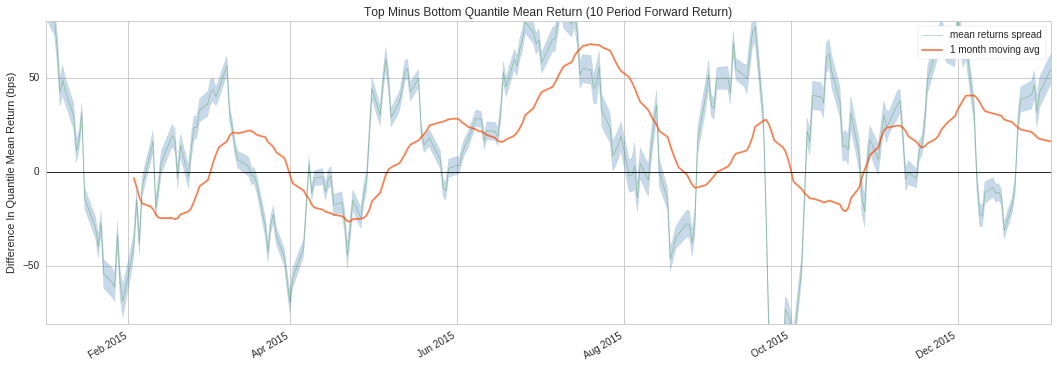

In [25]:
al.plotting.plot_mean_quantile_returns_spread_time_series(quant_return_spread, std_err_spread);

This next plot aggregates the returns of each individual quantile into a plot of cumulative returns separated by basket for the 1-period forward returns. What we want here is to see five discrete "fingers" with few to no crossovers. This will give us an idea of which quantiles tend to drive the returns (ideally the first and fifth).

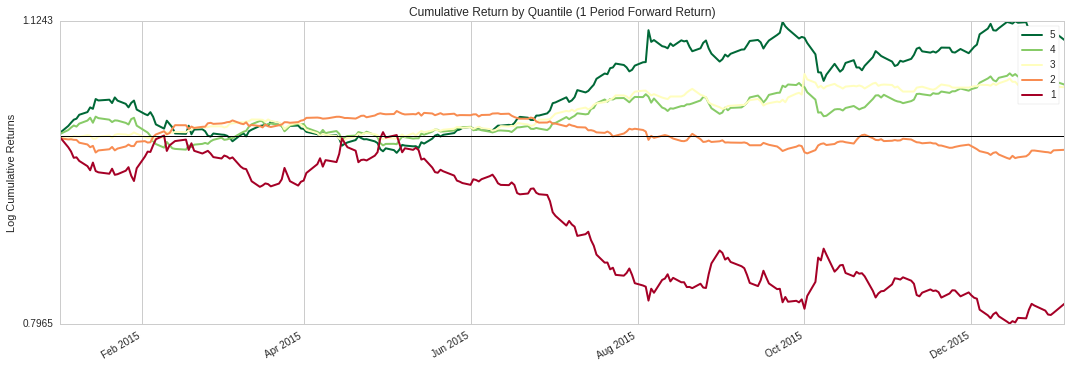

In [26]:
al.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q_daily);

This next function gives us the returns for each time period weighted by factor.

In [27]:
ls_factor_returns = al.performance.factor_returns(factor, forward_returns)

In [28]:
ls_factor_returns.head()

,1,5,10
date,,,
2015-01-02 00:00:00+00:00,0.002477,0.003598,0.003902
2015-01-05 00:00:00+00:00,0.006623,0.003799,0.003396
2015-01-06 00:00:00+00:00,0.002819,0.002940,0.002676
2015-01-07 00:00:00+00:00,0.003729,0.003183,0.001842
2015-01-08 00:00:00+00:00,0.000482,0.001653,0.002021


Here we plot the cumulative factor-weighted returns in a long-short portfolio. This shows the performance of the factor as a whole, which is always important to consider. A long-short portfolio will only involve the first and fifth quantiles.

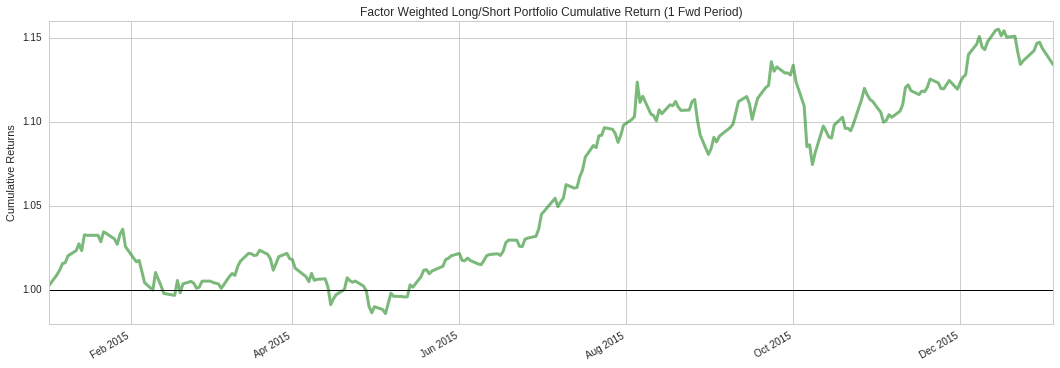

In [29]:
al.plotting.plot_cumulative_returns(ls_factor_returns[1]);

Now we calculate the $\alpha$ and $\beta$ of our factor with respect to the market. These are calculated by creating a regression of the market returns for each period against a long-short factor portfolio and extracting the parameters. These signify the excess return associated with our factor and the market beta, respectively.

In [30]:
alpha_beta = al.performance.factor_alpha_beta(factor,
                                              forward_returns,
                                              factor_returns=ls_factor_returns)

In [31]:
alpha_beta

,1,5,10
Ann. alpha,0.130145,0.117932,0.111589
beta,-0.097436,-0.227819,-0.255123


## Information Coefficient

We use the information coefficient (IC) to assess the predictive power of a factor. The IC of a factor is its Spearman Rank Correlation. For more background on the mathematics associated with the IC, check out the [Spearman Rank Correlation Lecture](https://www.quantopian.com/lectures#Spearman-Rank-Correlation). To break it down, we calculate the IC between the factor values and the forward returns for each period. The IC assesses the monotonic relationship between factors and returns. What this means, intuitively, is that it provides a measure for whether higher factor values can be associated with higher returns. A higher IC indicates that higher factor values are more closely associated with higher return values (and lower factor values with lower return values). A very negative IC indicates that higher factor values are closely associated with lower return values. An IC of $0$ indicates no relationship.

Using `Alphalens`, we extract the IC for each time period below.

In [32]:
ic = al.performance.factor_information_coefficient(factor, forward_returns)

In [33]:
ic.head()

,1,5,10
date,,,
2015-01-02 00:00:00+00:00,0.201253,0.361206,0.398440
2015-01-05 00:00:00+00:00,0.256116,0.326918,0.364527
2015-01-06 00:00:00+00:00,0.166451,0.260036,0.302310
2015-01-07 00:00:00+00:00,0.202764,0.232091,0.214805
2015-01-08 00:00:00+00:00,0.012961,0.139306,0.215462


Here we plot the IC as a time series for each period along with a 1-month moving average to smooth it out. What we want here is consistency over time and a consistently informative signal.

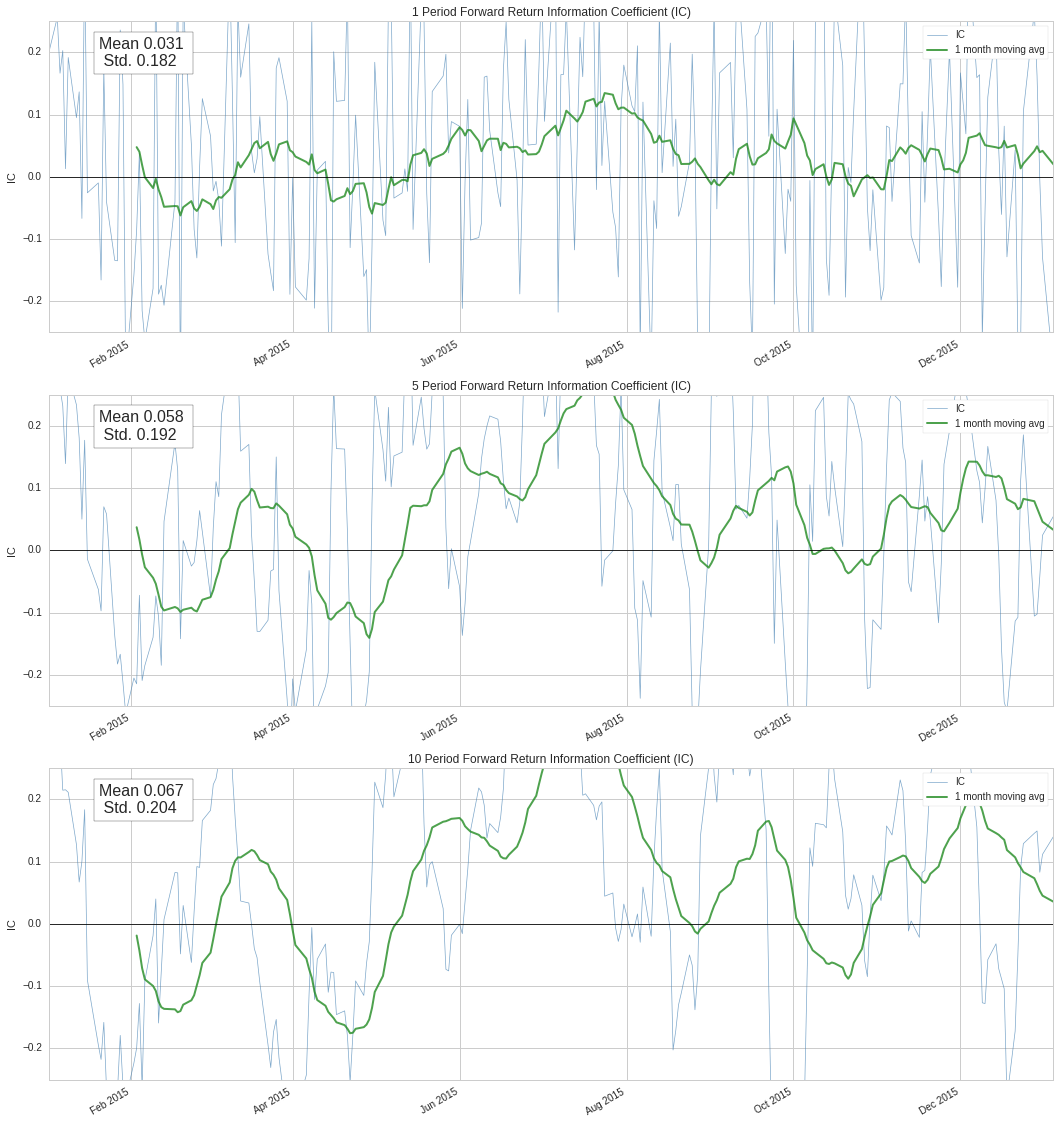

In [34]:
al.plotting.plot_ic_ts(ic);

Histograms are good to show us the distribution of the IC. These will clearly show any strange outliers and how they affect the overall curve.

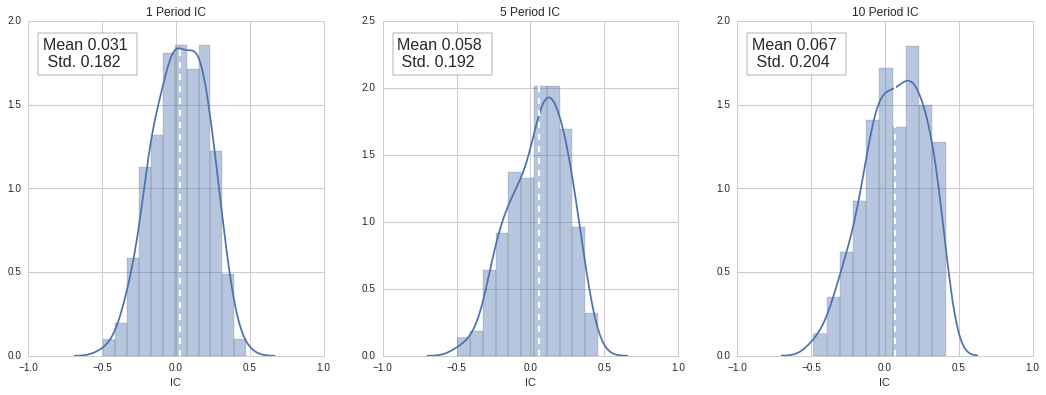

In [35]:
al.plotting.plot_ic_hist(ic);

A QQ-plot compares the distribution of the IC to the normal distribution. It plots the quantiles of one distribution against the quantiles of the other, typically with a reference line at $y = x$. If the points in the QQ-plot fall entirely along this line, this indicates that the two distributions are the same. In practice, a QQ-plot serves as a measure of similarity between distributions. Generally, what we want to see here is an S-shaped curve. This indicates that the tails of the IC distribution are fatter and contain more information.

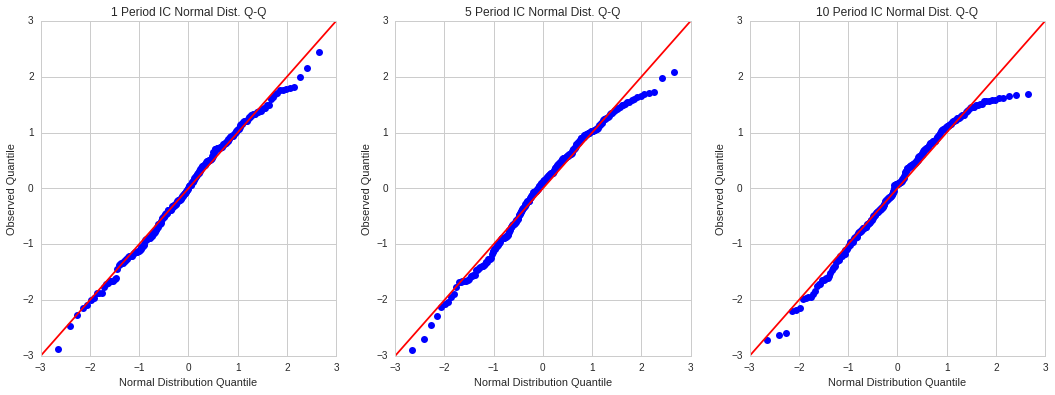

In [36]:
al.plotting.plot_ic_qq(ic);

The following heatplots show the monthly mean IC, providing us with another visual of consistency.

In [37]:
mean_monthly_ic = al.performance.mean_information_coefficient(factor, forward_returns, by_time='M')

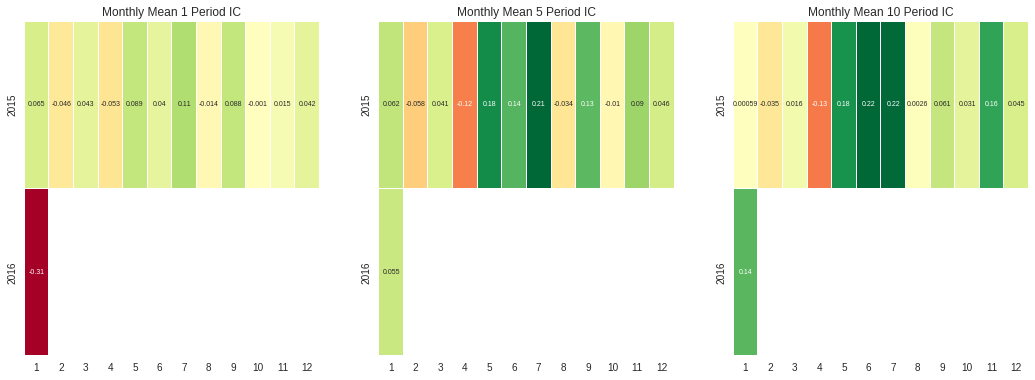

In [38]:
al.plotting.plot_monthly_ic_heatmap(mean_monthly_ic);

## Turnover

When considering the impact of actually implementing a signal in a strategy, turnover is a critical thing to consider. This plot shows the turnover of the top and bottom quantiles of your factor, the baskets that you would actually be trading on with a long-short approach. Excessive turnover will eat away at the profits of your strategy through commission costs. Sometimes a signal just isn't good enough to fight against the tide on the scale that you have to deal with through your broker.

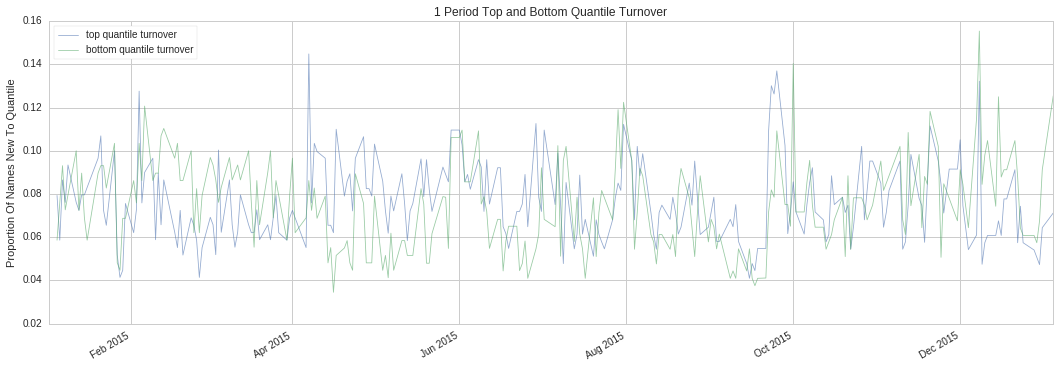

In [39]:
al.plotting.plot_top_bottom_quantile_turnover(quantized_factor);

This plot shows a fairly low turnover for the factor, implying that we will not be hit too hard by the consist changing of portfolio positions. We cannot see this directly, however, because `Alphalens` does not model commission costs. It simply provides metrics that we can use to judge a factor by itself. To properly model undermining influences such as slippage and commissions you will need to implement a strategy that uses your factor in the backtester.

## Autocorrelation

Factor autocorrelation is the measure of correlation between the current value of the factor and its previous value. The idea behind its calculation is to provide another measure of the turnover of the factor quantiles. If the autocorrelation is low, it implies that the current value of the factor has little to do with the previous value and that portfolio positions are changing frequently from time period to time period. If the next value of the factor is significantly influenced by its last value, this means that your ranking scheme is more consistent (though this has no influence on its ability to forecast relative price movements).

In [40]:
factor_autocorrelation = al.performance.factor_rank_autocorrelation(factor)

In [41]:
factor_autocorrelation.head()

date
2015-01-02 00:00:00+00:00         NaN
2015-01-05 00:00:00+00:00    0.987239
2015-01-06 00:00:00+00:00    0.988118
2015-01-07 00:00:00+00:00    0.987695
2015-01-08 00:00:00+00:00    0.988107
Name: 1, dtype: float64

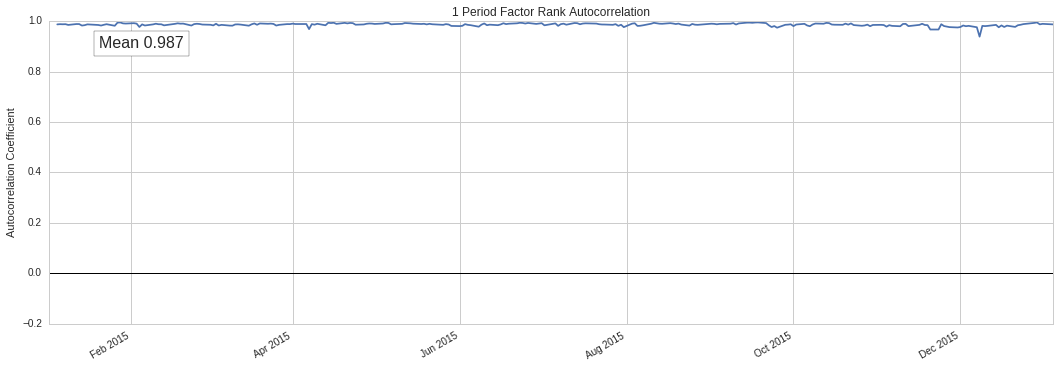

In [42]:
al.plotting.plot_factor_rank_auto_correlation(factor_autocorrelation);

In this case, we have fairly high autocorrelation, corroborating the turnover plots from above that suggested more consistent portfolio positions.

## Sector Analysis

In addition to all these other metrics, `Alphalens` provides a breakdown of IC and returns by industry sector. While it is good to consider breakdowns by quantile, it is also important to see how your factor is exposed to the different facets of the market. This is a good way to assess if your factor is behaving as it should in your universe. For example, if you intend your universe to only touch a certain sector, it is worthwhile to confirm that your factor and universe indeed only touch that sector.

Here we get the mean IC by sector for each time period.

In [43]:
ic_by_sector = al.performance.mean_information_coefficient(factor, forward_returns, by_group=True)

In [44]:
ic_by_sector.head()

,1,5,10
group,,,
Basic Materials,0.041329,0.065004,0.091422
Communication Services,0.004536,0.019752,0.023796
Consumer Cyclical,0.019541,0.038093,0.044130
Consumer Defensive,0.019402,0.047732,0.051820
Energy,0.037308,0.084451,0.106882


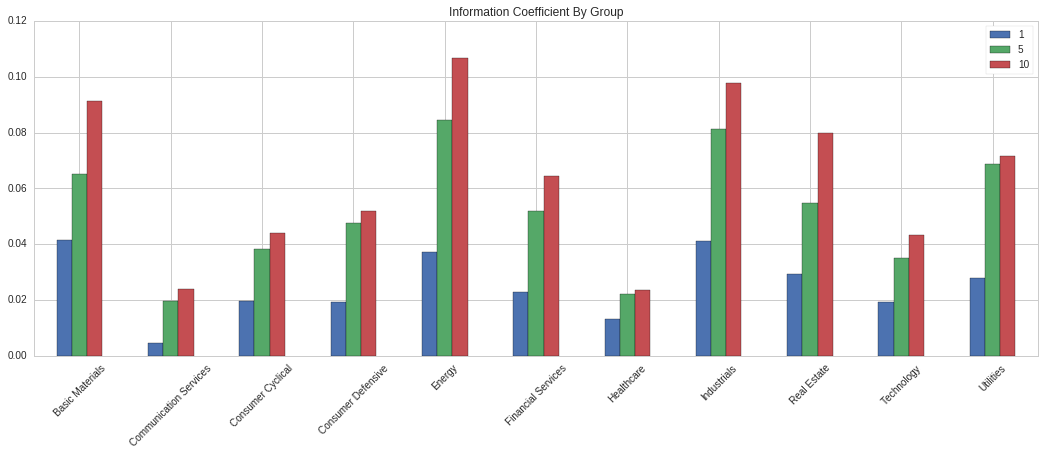

In [45]:
al.plotting.plot_ic_by_group(ic_by_sector);

Looking at the returns by quantile for each individual sector helps to show which sectors are driving the bulk of our returns as well as whether quantiles in each sector are broken out how they should be (with the lowest quantiles giving the lowest returns up to the highest quantiles giving the highest returns). If an individual sector has little to no signal (IC), it makes sense for the quantile returns to be all over the place. We want to make sure that everything is behaving nicely.

In [46]:
mean_return_quantile_sector, mean_return_quantile_sector_err = al.performance.mean_return_by_quantile(quantized_factor,
                                                                                                      forward_returns,
                                                                                                      by_group=True)

In [47]:
mean_return_quantile_sector.head()

1         5         10
group           quantile                              
Basic Materials 1        -0.001061 -0.001476 -0.001690
                2         0.000351  0.000393  0.000491
                3         0.000751  0.001068  0.001083
                4         0.000785  0.001078  0.001203
                5        -0.000333 -0.000210 -0.000043

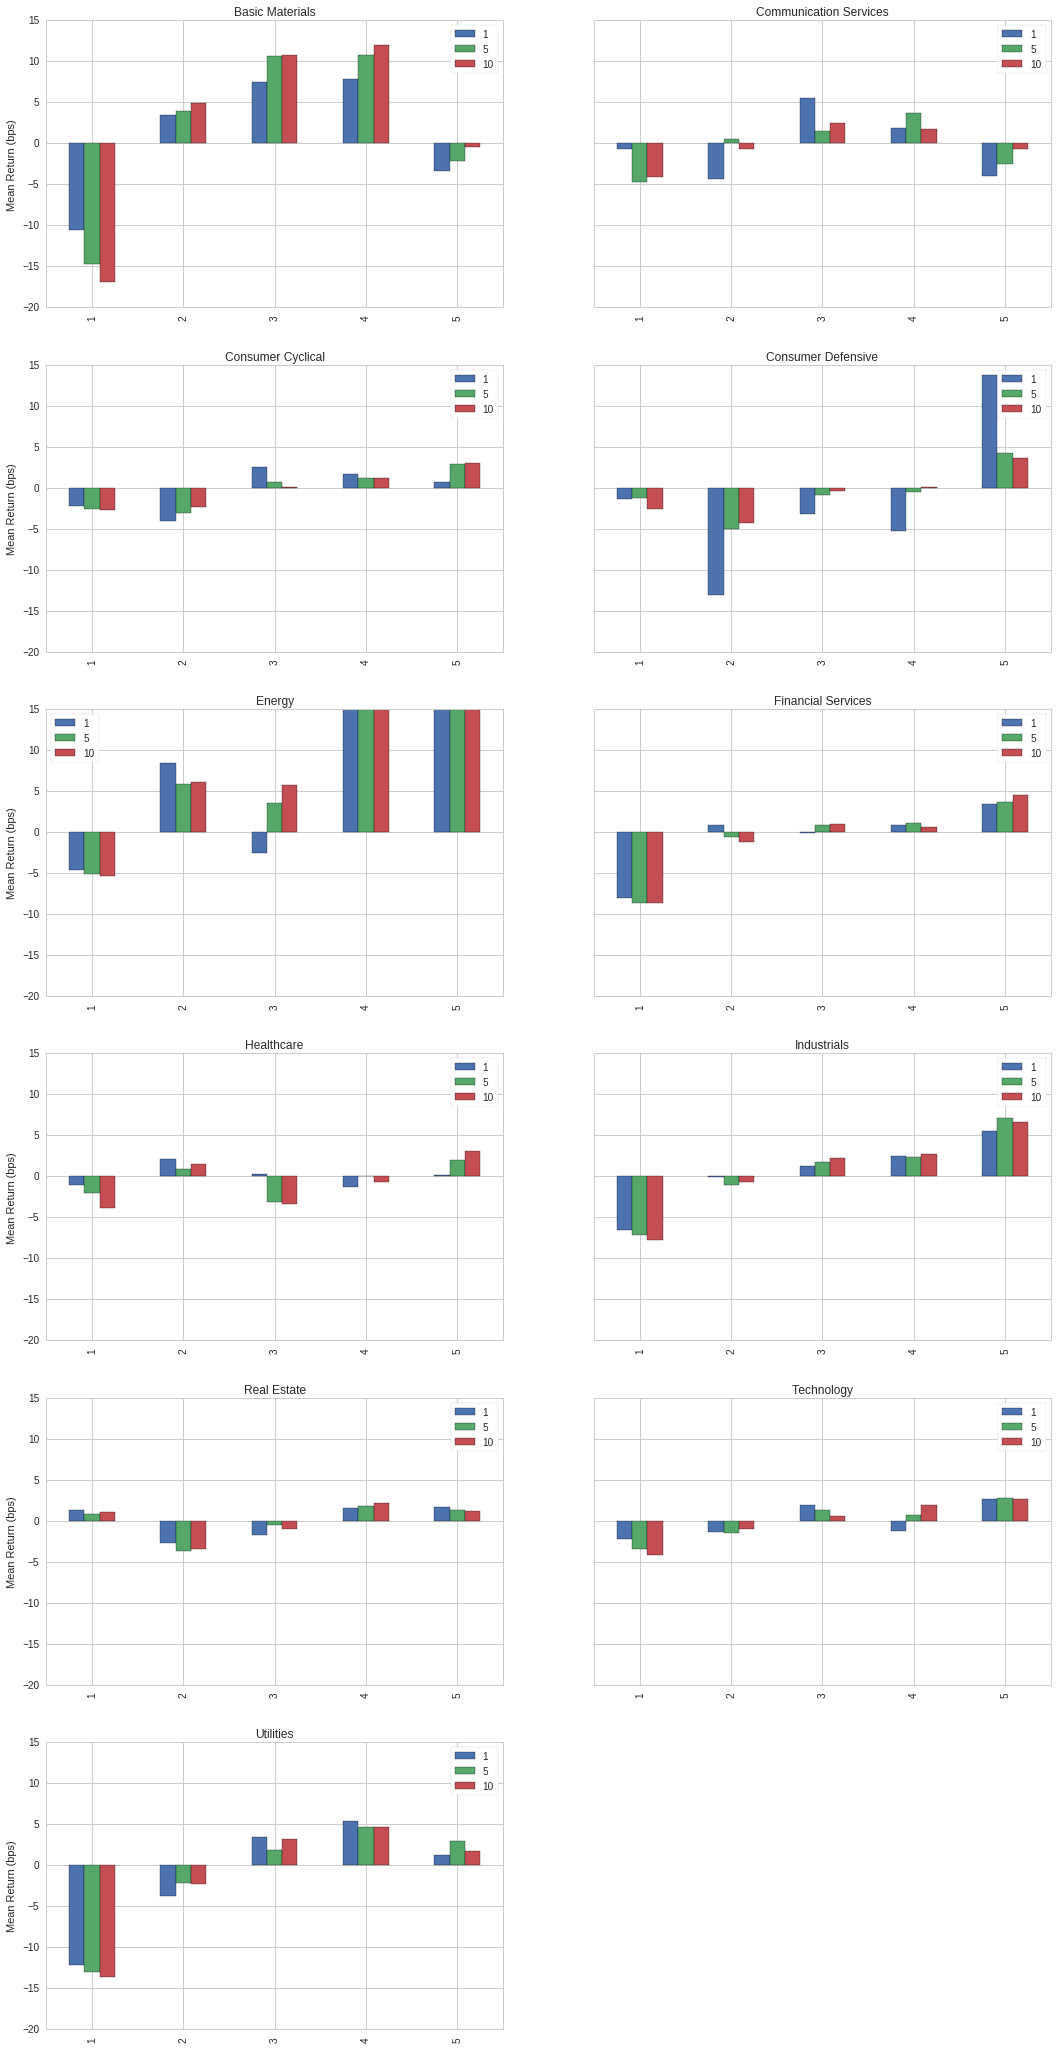

In [48]:
al.plotting.plot_quantile_returns_bar(mean_return_quantile_sector, by_group=True);

# The Short Version

You don't need to run all those different blocks of code, fortunately. In practice, we only need to pass in the initial, non-quantized factor values, the prices, the periods, and the groupby characteristics for sector breakouts. The syntax for generating the full tear sheet all at once is as follows:

Returns Analysis


,1,5,10
Ann. alpha,0.116,0.117,0.111
beta,-0.100,-0.227,-0.256
Mean Period Wise Return Top Quantile (bps),3.131,4.192,4.499
Mean Period Wise Return Bottom Quantile (bps),-7.323,-8.852,-9.553
Mean Period Wise Spread (bps),10.444,13.011,14.000


Information Analysis


,1,5,10
IC Mean,0.031,0.058,0.067
IC Std.,0.182,0.192,0.204
t-stat(IC),2.687,4.806,5.244
p-value(IC),0.008,0.000,0.000
IC Skew,-0.171,-0.357,-0.353
IC Kurtosis,-0.503,-0.494,-0.555
Ann. IR,2.681,4.797,5.233


Turnover Analysis


,1,5,10
Quantile 1 Mean Turnover,0.075,0.177,0.250
Quantile 2 Mean Turnover,0.170,0.369,0.482
Quantile 3 Mean Turnover,0.197,0.416,0.535
Quantile 4 Mean Turnover,0.174,0.378,0.497
Quantile 5 Mean Turnover,0.076,0.177,0.254


,1,5,10
Mean Factor Rank Autocorrelation,0.987,0.938,0.881


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:2790: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


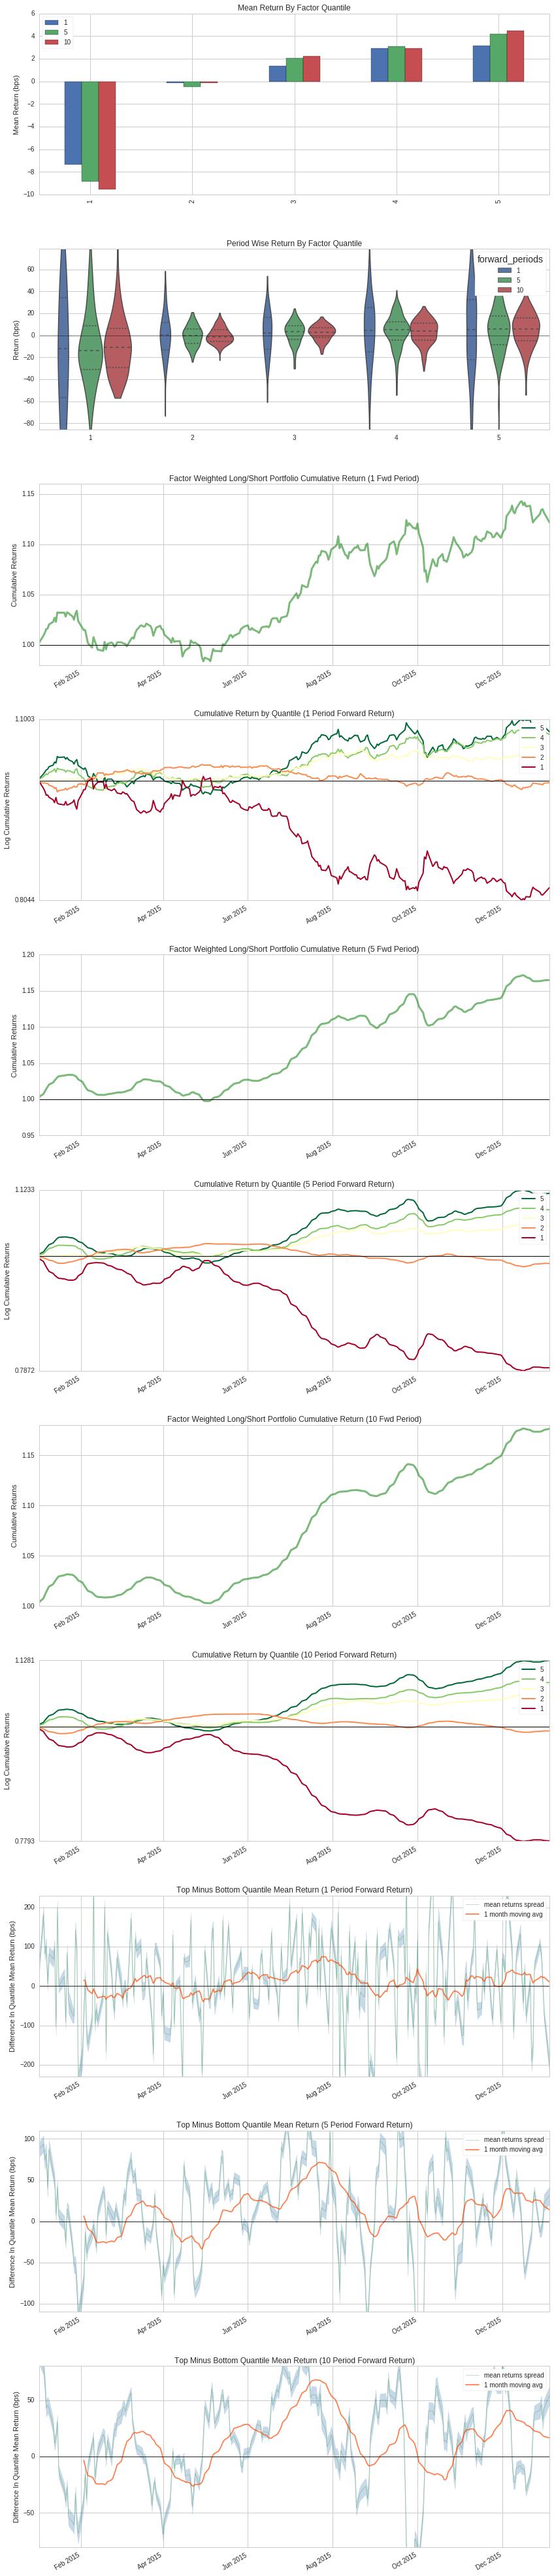

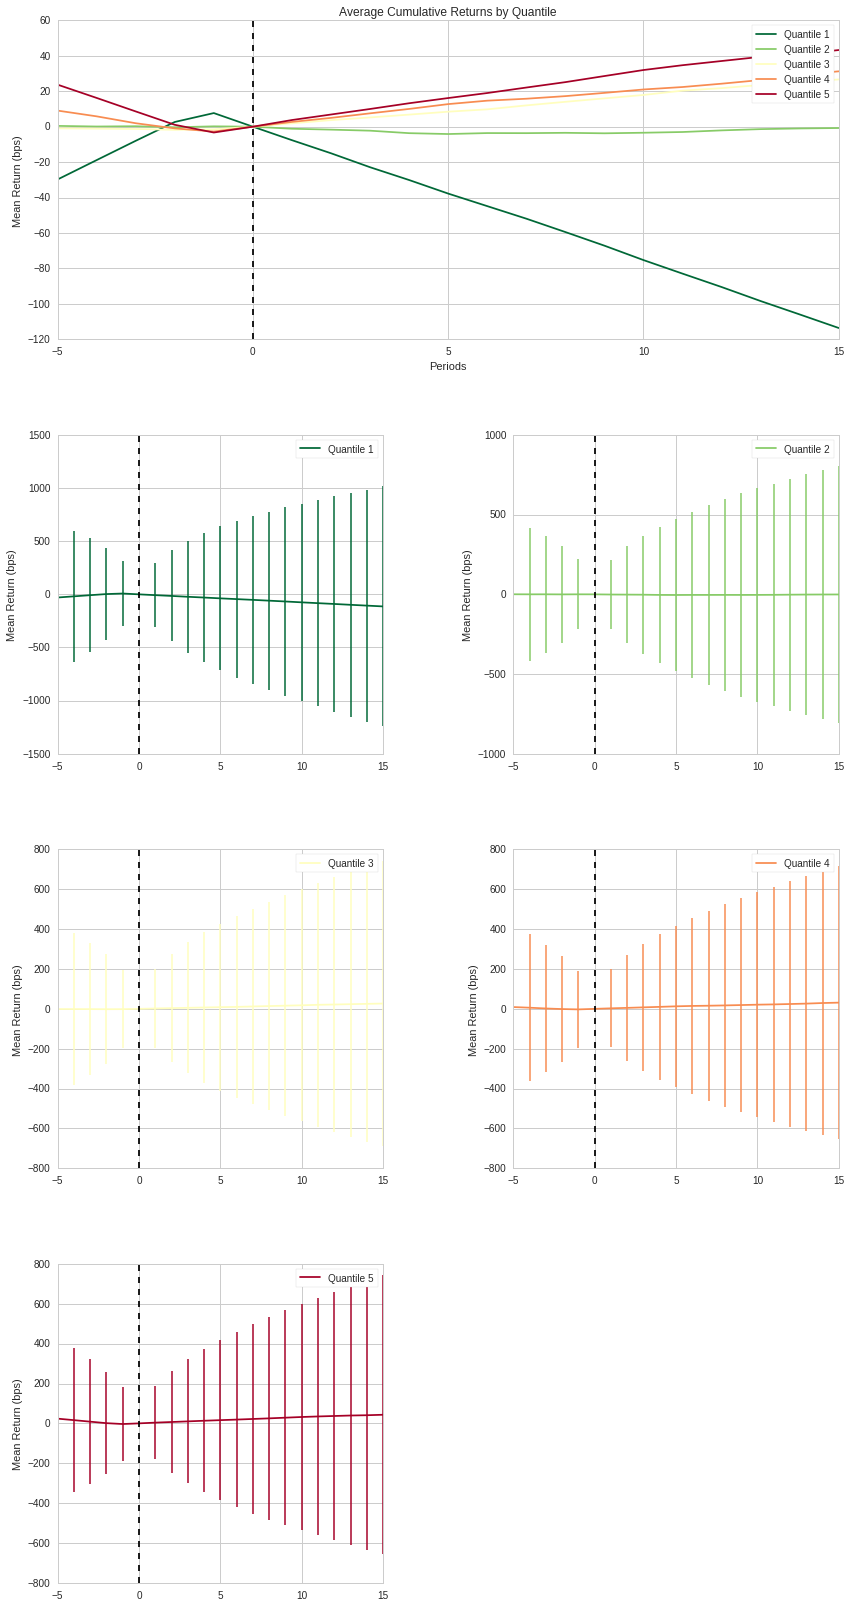

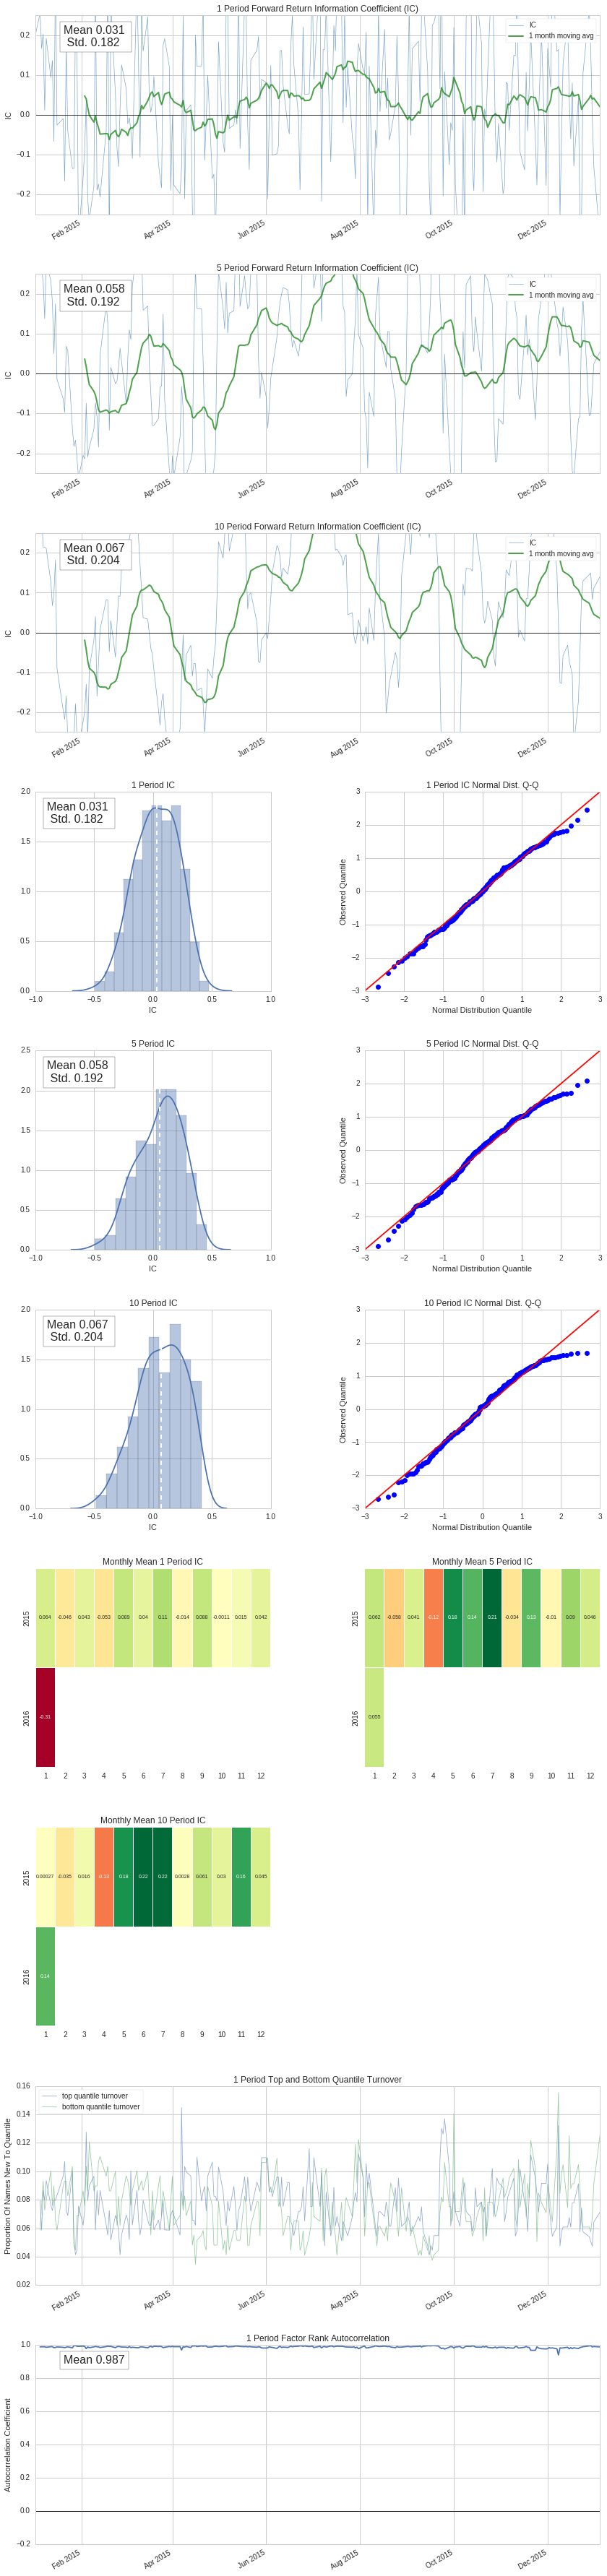

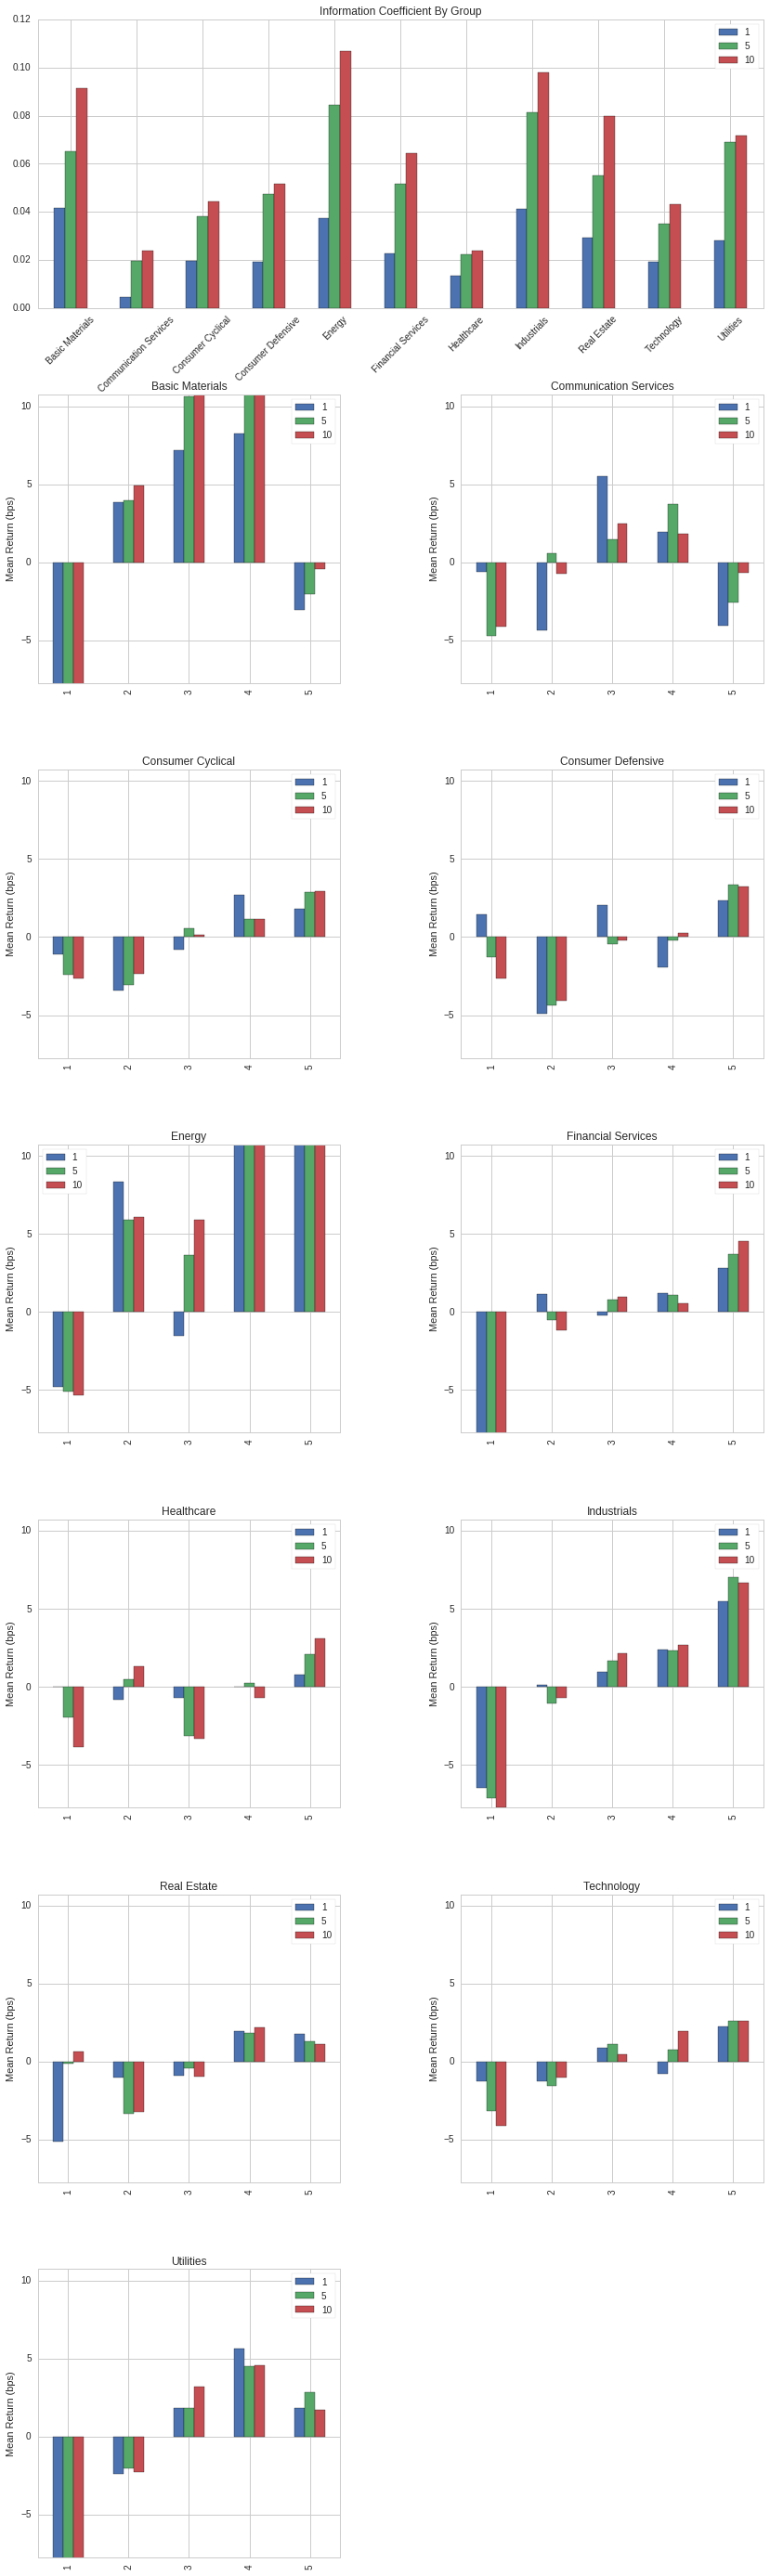

In [49]:
al.tears.create_factor_tear_sheet(my_factor,
                                  prices,
                                  groupby=sectors,
                                  groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                  periods=(1, 5, 10))

# More on Factors

Coming up with new factors is all well and good, but often you will need many independently predictive factors to produce a signal that is stable enough to trade. Methods of aggregating factors together will be discussed in future lectures, but a simple initial approach would just be to average the factor weights together and use this new weight as your ranking scheme.


# Next Steps

Once you have a factor that looks good, the next step is to implement it in an algorithm. Unfortunately, it isn't enough to simply have a good signal. Trading algorithms have to take into account many other considerations that are not included in `Alphalens`. We need to include how the market at large will react to the trades we're making (market impact/slippage) as well as the transaction costs associated with making those trades. These influences can erode our profits if we do not properly assess their impact through extensive testing.

To this end, we have the full backtesting environment. It allows for slippage and transaction cost modeling and lets you set limitations for the amount of leverage (debt) that your algorithm can take on to make its trades. Learn more about leverage [here](https://www.quantopian.com/lectures#Leverage).

We have an [example long-short algorithm](https://www.quantopian.com/lectures#Example:-Long-Short-Equity-Algorithm) that you can clone and use to test your own factors. Try adding in the momentum factor that we played within this lecture to see how our extra considerations affect the trades made and the resultant profits.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*